In [1]:
#Import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import html

import collections
from collections import Counter


#!pip install wordcloud
import wordcloud
from wordcloud import WordCloud

from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import warnings
#warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /Users/Yunhao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Yunhao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Yunhao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Import Original data

The purpose of this analysis is to compute the sentiment of text information, which is related to the tweets posted in 2019 Canadian elections, to answer the question "What can public opinion on Twitter tell us about the Canadian political lanscape in 2019?"

There are two input files:
1. Sentiment.csv
2. Canadian_elections_2019.csv

"Sentiment.csv" contains 133811 labeled generic tweet texts with two columns: sentiment, text <br>
"Canadian_elections_2019.csv" contains 2133 labeled generic tweet texts with three columns: sentiment, negative_reason, text

In [2]:
#Input file
input_file_sentiment = 'Sentiment.csv'
input_file_election = 'Canadian_elections_2019.csv'
Sentiment = pd.read_csv(input_file_sentiment, low_memory=False)
Election = pd.read_csv(input_file_election, low_memory=False)
print(Sentiment.shape)
print(Election.shape)

(133811, 2)
(2133, 3)


In [3]:
Sentiment.head() 

,sentiment,text
0,Positive,RT @Diplomtc_Immnty: @realDonaldTrump They tri...
1,Negative,"@chiefy74 Damn i'm jealous, i wanna watch the ..."
2,Positive,I'm listening The Beatles now. They're great
3,Positive,@ddlovato could i please get a shout out or an...
4,Positive,@salspizza just spotted ur message there Tony ...


In [4]:
Election.tail()

,sentiment,negative_reason,text
2128,Negative,Scandal,b'You know he was doing a good enough job smea...
2129,Negative,Scandal,b'You missed the comment. Deflecting the issue...
2130,Positive,NaN,b'Your daily reminder:\n@theJagmeetSingh endor...
2131,Negative,Women Reproductive right and Racism,b'Yup...not going to reopen the abortion debat...
2132,Positive,NaN,b'Zing.\n#NDP #elxn43 https://t.co/xo6Qe4jV3p'


In [5]:
def remove_emoji(tweets):
    return re.sub(r'(\\x(.){2})', '',tweets)

Election['cleaned_text'] = Election['text'].apply(remove_emoji)

We can observe that in the Election 'text' column the contents all start with b" which is an indication of data type of bytes. It does not contribute any meaning thus remove the first two characters in each text helps clean the tweet and benefits later analysis.

In [6]:
def remove_b(tweet):
    tweet = str(tweet)
    return tweet[2:]

Election['cleaned_text'] = Election['cleaned_text'].apply(remove_b)
Election.tail(8)

,sentiment,negative_reason,text,cleaned_text
2125,Negative,Others,b'You can\xe2\x80\x99t be a supervillain of an...,You cant be a supervillain of an election if y...
2126,Negative,Climate Problem,b'You care about limiting #ClimateChange and a...,You care about limiting #ClimateChange and are...
2127,Positive,NaN,b'You heard it here first. Head to https://t.c...,You heard it here first. Head to https://t.co/...
2128,Negative,Scandal,b'You know he was doing a good enough job smea...,You know he was doing a good enough job smeari...
2129,Negative,Scandal,b'You missed the comment. Deflecting the issue...,You missed the comment. Deflecting the issue d...
2130,Positive,NaN,b'Your daily reminder:\n@theJagmeetSingh endor...,Your daily reminder:\n@theJagmeetSingh endorse...
2131,Negative,Women Reproductive right and Racism,b'Yup...not going to reopen the abortion debat...,Yup...not going to reopen the abortion debate....
2132,Positive,NaN,b'Zing.\n#NDP #elxn43 https://t.co/xo6Qe4jV3p',Zing.\n#NDP #elxn43 https://t.co/xo6Qe4jV3p'


## 1. Data cleaning

**Procedure:**: 
1. All html tags and attributes (i.e., /<[^>]+>/) are removed.
2. Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
3. All URLs are removed.
4. All characters in the text are in lowercase.
5. All stop words are removed. Be clear in what you consider as a stop word. 
6. If a tweet is empty after pre-processing, it should be preserved as such.


In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

In [8]:
# Remove html tags and attributes
def remove_tags(tweet):
    tags = re.compile(r'<[^>]+>')
    return re.sub(tags, ' ', str(tweet))

# Replace html with ASCII equivalent
def html_ascii(tweet):
    return html.unescape(tweet)

# Remove all URLs
def remove_url(tweet):
    urls = re.compile(r'\s*(?:https?:\/\/)?[\w.-]+(?:\.[\w.-]+)+[\w\-._~:/?#[\]@!\$&\'\(\)\*\+,;=.]+')
    return re.sub(urls, ' ', str(tweet))

# Make all characters lower case
def lowercase(tweet):
    return tweet.lower()

# Before remove the stopwords, tokenize the tweets first
def tokenize(tweet):
    tok_tweet = nltk.tokenize.word_tokenize(tweet)
    return ' '.join(tok_tweet)

def remove_stopwords(tweet):
    words = tweet.split()
    clean_tweet = [word for word in words if word not in stopwords.words('english')]
    return ' '.join(clean_tweet)

def remove_nonAlphaNum(tweet):
    return re.sub(r'[^\s\w]+', '', tweet)

def preprocessing(tweet):
    tweet = remove_tags(tweet)
    tweet = html_ascii(tweet)
    tweet = remove_url(tweet)
    tweet = lowercase(tweet)
    tweet = tokenize(tweet)
    tweet = remove_stopwords(tweet)
    tweet = remove_nonAlphaNum(tweet)
    return tweet
    
Sentiment['cleaned_text'] = Sentiment['text'].apply(preprocessing)
Election['cleaned_text'] = Election['cleaned_text'].apply(preprocessing)

In [9]:
Sentiment.tail()

,sentiment,text,cleaned_text
133806,Positive,"@scottw Nice, I have the 20/20 but to be hones...",scottw nice 2020 honest nt think really need...
133807,Positive,â€œ@BW_React: #GOPDebate verdict: @JohnKasich ...,âœ bw_react gopdebate verdict johnkasich ...
133808,Negative,@amtrack i am sorry .... i love you tho and t...,amtrack sorry love tho thats matters hahahaha
133809,Positive,@RazorTV http://tinyurl.com/d96txo - Champions...,razortv champions league 25 free bet
133810,Negative,"Beautiful day, and I'm on my way to the office...",beautiful day m way


In [10]:
Election.tail()

,sentiment,negative_reason,text,cleaned_text
2128,Negative,Scandal,b'You know he was doing a good enough job smea...,know good enough job smearing campaign right ...
2129,Negative,Scandal,b'You missed the comment. Deflecting the issue...,missed comment deflecting issue answer best ...
2130,Positive,NaN,b'Your daily reminder:\n@theJagmeetSingh endor...,daily reminder n thejagmeetsingh endorses st...
2131,Negative,Women Reproductive right and Racism,b'Yup...not going to reopen the abortion debat...,going reopen abortion n elxn43 scheerlies s...
2132,Positive,NaN,b'Zing.\n#NDP #elxn43 https://t.co/xo6Qe4jV3p',zingn ndp elxn43


## 2.0 Exploratory Analysis

### 2.1 Label the tweet with associated political party
Design a simple procedure that determines the political party (Liberal, Conservative, NDP, None) of a given tweet and apply this procedure to all the tweets in the 2019 Canadian elections dataset. 

After the 2019 Canadian federal election, the seat distribution in the House of Commons is presented as follows:
1. Liberal party: 157
2. Conservative party:121
3. Bloc Québécois: 32
4. New Democratic: 24
5. Green party: 3

Relevant words and hashtags for political parties involved in election
1. Liberal party: 
   - Leader: Justin Trudeau, twitter account: @JustinTrudeau
   - Slogan: "chooseforward"
   - Official hashtag: #lpc 
<br>
<br>
2. Conservative party:
   - Leader: Andrew Scheer, twitter account: @AndrewScheer
   - Slogan: "It's time for you to get ahead."
   - official hashtag: #cpc
<br>
<br>
3. Bloc Québécois: 
   - Leader: Yves-François Blanchet, twitter account: @yfblanchet
   - Slogan: "Quebec, it is us"
   - official hashtag: #ptbloc
<br>
<br>
4. New Democratic:
   - Leader: Jagmeet Singh, twitter account: @theJagmeetSingh
   - Slogan: "In it for you"
   - official hashtag: #ptndp
<br>
<br>
5. Green party: 3
   - Leader: Elizabeth May, twitter account: @ElizabethMay
   - Slogan: "Not left. Not right. Forward together"
   - official hashtag: #ptgreen

In [11]:
Election_df = Election.copy()
Election_df.drop(['text'],axis=1,inplace=True)

**Procedure**:
1. Create strings containing keywords and hashtags identified above
2. Similar to One-hot encoding, create columns related to each party and label the tweet with true and false based on whether the tweet text contains keywords

**Justification**:
Using one-hot encoding, each tweet will be labeled with its associated party or parties since it is very likely that two or more parties are mentioned and compared in one single tweet. Tweet with 5 false labels is determined as not relevant to the election. <br>
However, this method may introduce bias and error due to mislabel. A tweet related to parties may not contain the keywords presented in the keyword list. It may decrease the model prediction accuracy a little.

In [12]:
# Since the text has been preprocessed into lower cases, the keywords list should also be in lower case.
#Liberal party keywords
keywords_liberal = 'justin|trudeau|justintrudeau|liberal|lpc|chooseforward'
#Conservative party keywords
keywords_conservative = 'andrew|scheer|andrewscheer|conservative|cpc|getahead'
#Bloc Québécois party keywords
keywords_bq = 'yves|françois|blanchet|yfblanchet|bloc|bq|ptbloc|quebec'
#New Democratic party keywords
keywords_ndp = 'jagmeet|singh|thejagmeetsingh|ndp|democratic|ptndp|initforyou'
#Green party keywords
keywords_green = 'elizabeth|may|elizabethmay|green|greenparty|ptgreen|notleft|notright|forwardtogether'

#create list of keywords
keywords=[keywords_liberal, keywords_conservative, keywords_bq, keywords_ndp, keywords_green]

#create list of parties
parties = ['Liberal', 'Conservative', 'Bloc Québécois', 'New Democratic', 'Green']

for party, keyword in zip(parties, keywords):
    Election_df[party] = Election_df['cleaned_text'].str.contains(keyword)

Election_df.head()

,sentiment,negative_reason,cleaned_text,Liberal,Conservative,Bloc Québécois,New Democratic,Green
0,Negative,Women Reproductive right and Racism,rosiebarton instead suggestion agree canadi...,False,True,False,False,False
1,Positive,NaN,allwomanspacewalk s real n space_station n ...,False,False,False,False,False
2,Negative,Economy,brantford s going cost 94 billion next 4 yea...,True,False,False,False,False
3,Positive,NaN,canada canadaelection2019 canadavotes n el...,False,False,False,False,False
4,Negative,Economy,canada taxpayers sick tired hard earned do...,True,False,False,False,False


In [13]:
# Convert false and true to 0 and 1
Election_df[parties]=Election_df[parties].astype(int)
Election_df.head()

,sentiment,negative_reason,cleaned_text,Liberal,Conservative,Bloc Québécois,New Democratic,Green
0,Negative,Women Reproductive right and Racism,rosiebarton instead suggestion agree canadi...,0,1,0,0,0
1,Positive,NaN,allwomanspacewalk s real n space_station n ...,0,0,0,0,0
2,Negative,Economy,brantford s going cost 94 billion next 4 yea...,1,0,0,0,0
3,Positive,NaN,canada canadaelection2019 canadavotes n el...,0,0,0,0,0
4,Negative,Economy,canada taxpayers sick tired hard earned do...,1,0,0,0,0


**Distribution of political affliation of tweets**: <br>
Observations: <br>
The rank of party affliated tweets count: Conservative > Liberal > New Democratic > Green > Bloc Québécois

Discussion:

The distribution of the political affliation of tweets generally represents the seat distribution in the House of Commons, which is a straight/direct indication of support distribution across Canada.

   - As the Liberal and Conservative party have the similar highest party affliated tweets counts, these two parties occupy the vast majority of the seat in the House of Commons.
   <br>
   - Liberal and Conservative party have close party affliated tweets counts, which suggests both parties have similar number of supporters on Twitter. This is one of the reason that the Liberal party fails to form a majority government during 2019 federal election.
   
   - The party affliated tweets count of New Democratic party is more than that of Green party. Also, New Democratic party occupies more seats in House of Common than Green party does.
   
   - The party affliated tweets count of Bloc Québécois is the representation of inherent problem with the dataset. The tweet text collected are in English and the keywords list does not contain French. Majority of Bloc Québécois supporters are in Quebec and they mainly use French.

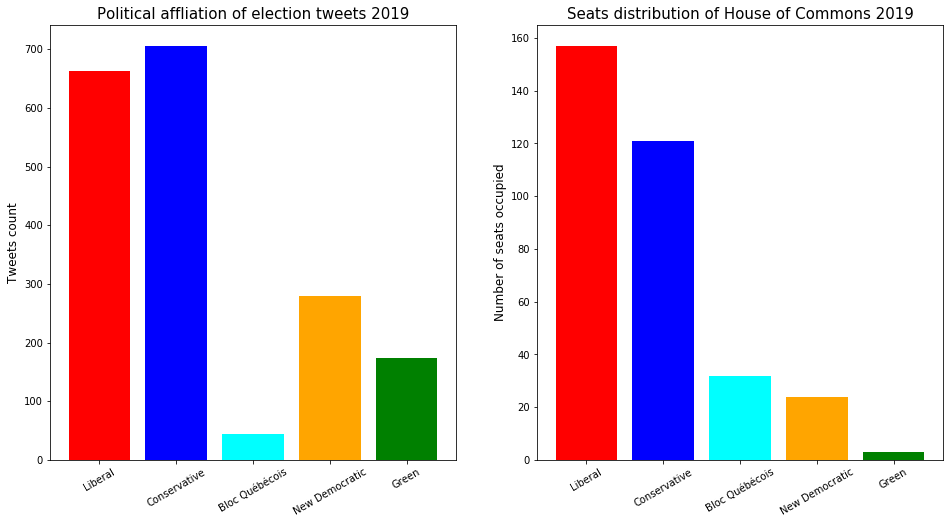

In [14]:
parties = ['Liberal', 'Conservative', 'Bloc Québécois', 'New Democratic', 'Green']
color = ['red', 'blue', 'cyan', 'orange', 'green']
seats = [157, 121, 32, 24,3]

fig, axs = plt.subplots(1,2, figsize=(16,8))
plt.sca(axs[0])

Number_tweet =[]
for party in parties:
    number_t = Election_df[party].value_counts()[1]
    Number_tweet.append(number_t)

x_tick = np.arange(len(parties))

plt.bar(x_tick, Number_tweet, color=color)
axs[0].set_xticks(x_tick)
axs[0].set_xticklabels(parties, fontsize=10, rotation = 30)
plt.ylabel('Tweets count', fontsize = 12)
plt.title('Political affliation of election tweets 2019', fontsize=15)

plt.sca(axs[1])
plt.bar(x_tick, seats, color=color)
axs[1].set_xticks(x_tick)
axs[1].set_xticklabels(parties, fontsize=10, rotation = 30)
plt.ylabel('Number of seats occupied', fontsize = 12)
plt.title('Seats distribution of House of Commons 2019', fontsize=15);


### 2.2 Dataset visualization

#### 2.2.1 Sentiment.csv tweets with positive sentiment

The tweets with positive sentiment from Sentiment.csv contain positive emotion words such as 'love', 'lol', 'thank' and 'good'. These high frequency words show that the users presented with postitive sentiment have good emotions and hope for the future life.

In [15]:
def split_list_into_word(tweet_list):
    words_list = []
    templist = []
    for i in range(len(tweet_list)):
        templist = tweet_list[i].split()
        for word in templist:
            words_list.append(word)
    return words_list

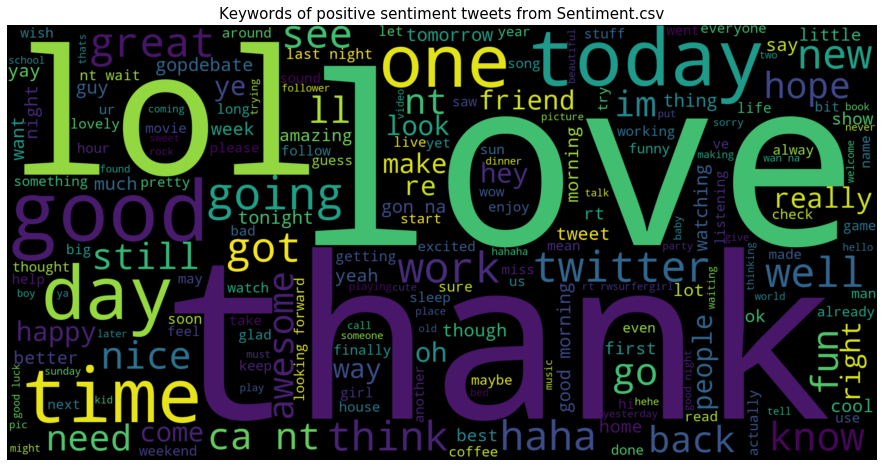

In [16]:
Sentiment_df = Sentiment.copy()
positive_sentiment_list = []

for i in range (Sentiment_df.shape[0]):
    sentiment = Sentiment_df['sentiment'][i]
    if sentiment == 'Positive':
        positive_sentiment_list.append(Sentiment_df['cleaned_text'][i])

positive_words_list = split_list_into_word(positive_sentiment_list)
positive_words_list = ' '.join(positive_words_list)

wordcloud = WordCloud(width=2000, height=1000).generate(positive_words_list)

plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keywords of positive sentiment tweets from Sentiment.csv', fontsize=15);

#### 2.2.2 Wordcloud visualization for the 2019 Canadian election tweets with positive sentiment (Bonus)

- The most common words for the positive sentiment such as elxn43 and cdnpoli are the hashtags that tagged to almost every tweet related to the election. They do not provide any meaningful information on the sentiment. Instead, they have negative impacts on the prediction algorithms since they are the noise in the dataset.
- Apart from the noise words, the words showed up frequently are related to the Liberal party such as 'liberal', 'justintrudeau' and 'chooseforward'. 

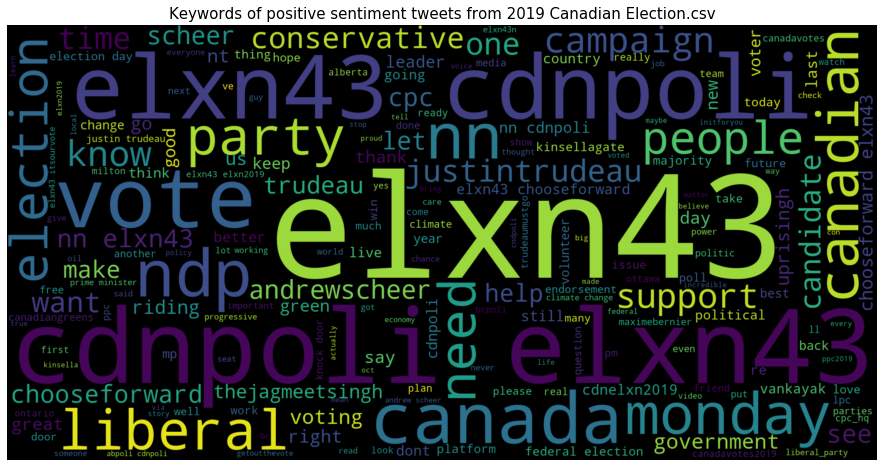

In [17]:
positive_sentiment_list = []

for i in range (Election_df.shape[0]):
    sentiment = Election_df['sentiment'][i]
    if sentiment == 'Positive':
        positive_sentiment_list.append(Election_df['cleaned_text'][i])

positive_words_list = split_list_into_word(positive_sentiment_list)
positive_words_list = ' '.join(positive_words_list)

wordcloud = WordCloud(width=2000, height=1000).generate(positive_words_list)

plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keywords of positive sentiment tweets from 2019 Canadian Election.csv', fontsize=15);

#### 2.2.2 Canadian election 2019 tweets.csv sentiment ratio for each party

From the following figure, it can be found that: <br>

- The ratio of positive sentiment and negative sentiment tweets for Liberal party is around fifty-fifty.
- The majority of the tweets related with Conservative party is with negative sentiment.
- The majority of the tweets related with New Democratic party is with positive sentiment. 
- Overall, the Liberal party receives the highest number of tweets with positive sentiment


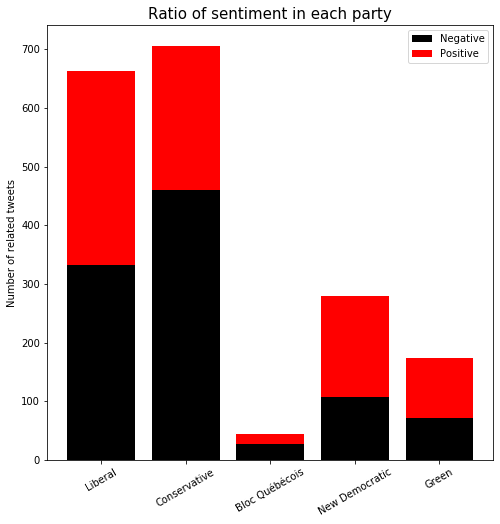

In [18]:
parties = ['Liberal', 'Conservative', 'Bloc Québécois', 'New Democratic', 'Green']
Number_tweet =[]
Number_positive= []

for party in parties:
    number_t = Election_df[party].value_counts()[1]
    Number_tweet.append(number_t)
    count = 0
    for j in range(Election_df.shape[0]):
        if Election_df['sentiment'][j] == 'Positive' and Election_df[party][j] == 1:
            count= count+1
    Number_positive.append(count)

Number_tweet = np.array(Number_tweet)
Number_positive = np.array(Number_positive)
Number_negative = Number_tweet - Number_positive

idx = np.arange(len(parties))

plt.figure(figsize=(8,8))
plt.bar(idx, Number_negative, color='black', label = 'Negative')
plt.bar(idx, Number_positive, bottom = Number_negative, color='red', label = 'Positive')
plt.xticks(idx, parties, fontsize=10, rotation = 30)
plt.ylabel('Number of related tweets', fontsize = 10)
plt.title('Ratio of sentiment in each party', fontsize = 15)
plt.legend()

### 3.0 Model preparation
Split the generic tweets from Sentiment.csv file randomly into training data (70%) and test data (30%). Prepare the data to try multiple classification algorithms (logistic regression, k-NN, Naive Bayes, SVM, decision trees, ensembles (Random Forest, XGBoost)), where each tweet is considered a single observation/example. In these models, the target variable is the sentiment value, which is either positive or negative. Try two different types of features, word frequency (WF) and TF-IDF.

In [19]:
# Preprocess the dataframe to cleaned_text and convert target values from Positve, Negative to 1 and 0
Sentiment_df = Sentiment.copy()
Sentiment_df.drop(['text'], axis=1, inplace = True)
Sentiment_df['sentiment']=Sentiment_df['sentiment'].replace(to_replace=['Positive', 'Neutral','Negative'], 
                                                                         value=[1, 0, -1])
Sentiment_df.head()

,sentiment,cleaned_text
0,1,rt diplomtc_immnty realdonaldtrump tried ta...
1,-1,chiefy74 damn m jealous wan na watch fight l...
2,1,m listening beatles re great
3,1,ddlovato could please get shout anything m h...
4,1,salspizza spotted ur message tony replied


In [20]:
Sentiment_df['sentiment'].value_counts()

-1    71428
 1    59241
 0     3142
Name: sentiment, dtype: int64

#### 3.1 Word frequency (WF) feature method
Word frequency method records the frequency of each word showed up in each tweet. This method converts the original dataframe to new dataframe with feature columns and a label column. 

In [21]:
class Feature_WF(object):
    # class initiation function
    def __init__(self,dataFrame):
        super().__init__()
        self.dataFrame = dataFrame
    
    # Convert the original dataframe to new dataframe with feature columns and label column
    def convert(self, text_column, label_column, top_k):
        return self.word_frequency(text_column,label_column,top_k)
    
    # Lemmatizer converts the words with different tenses back to their basic form
    # Counter function counts each unique word and its frequency
    def count_words(self, tweet):
        stop = stopwords.words('english')
        lemmatizer = WordNetLemmatizer()
        word_counter = Counter()
        for text in tweet:
            words = [lemmatizer.lemmatize(i) for i in text.split() if i not in stop]
            word_counter.update(words)
        return word_counter
    
    # First find the top k most common words
    # Then find the frequency of these top k common words showed up in each tweet
    def word_frequency(self, text_column, label_column,top_k):
        w_cnt = self.count_words(self.dataFrame[text_column])
        word_list = [word for (word, freq) in w_cnt.most_common(top_k)]
        rows = []
        for text in self.dataFrame[text_column]:
            text_words_counter = self.count_words([text])
            rows.append([text_words_counter[word] if text_words_counter[word]>0 else 0 for word in word_list])

        X = pd.DataFrame(rows, columns = word_list)
        Y = self.dataFrame[label_column]
        dataframe_WF = X.copy()
        dataframe_WF['label'] = Y
        return dataframe_WF

In [22]:
WFconverter = Feature_WF(Sentiment_df)
Sentiment_WF = WFconverter.convert('cleaned_text', 'sentiment', 500)

In [23]:
X_wf = Sentiment_WF.iloc[:,0:-1].values
y_wf = Sentiment_WF.iloc[:,-1].values
X_wf.shape

(133811, 500)

#### 3.2 Term Frequency–Inverse Document Frequency (TF-IDF)

A numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

In [24]:
class Feature_TFIDF(object):
    def __init__(self,dataFrame):
        super().__init__()
        self.dataFrame = dataFrame

    def convert(self,text_column,label_column):
        return self.tf_idf(text_column,label_column)

    def tf_idf(self,text_column,label_column):
        tfidf_vector = TfidfVectorizer(stop_words='english')
        X = tfidf_vector.fit_transform(self.dataFrame[text_column])
        Y = self.dataFrame[label_column]
        
        return X, Y

In [25]:
Convertor = Feature_TFIDF(Sentiment_df)
X_tf, y_tf= Convertor.convert('cleaned_text','sentiment')
X_tf

<133811x107692 sparse matrix of type '<class 'numpy.float64'>'
	with 910979 stored elements in Compressed Sparse Row format>

#### 3.3 training data and test data split
Split the generic tweets from Sentiment.csv file randomly into training data (70%) and test data (30%)

In [26]:
# For word frequency feature method data
X_train_wf, X_test_wf, y_train_wf, y_test_wf = train_test_split(X_wf, y_wf, 
                                                                test_size = 0.30, random_state=0, shuffle=False)

In [27]:
# For TF-IDF feature method data
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf, y_tf, 
                                                                test_size = 0.30, random_state=0, shuffle=False)

### 4.0 Model Implementation

**Procedure:**
1. Compare the two features method: word frequency (WF) and Term Frequency-Inverse Document Frequency.
2. Train multiple classification algorithms on the Sentiment.csv training dataset and use grid search method to find their corresponding optimal hyperparameters. 
3. Compare the optimized classification algorithms based on their performance on the Sentiment.csv test dataset.
4. Record the hyperparameters of the optimized classification model with best performance
5. Convert the 2019 Election.csv with the better feature method determined from step 1
6. Train test split the converted 2019 election tweets with a test size of 0.3.
7. Fit the best classification model determined from step 4 to the training dataset. Test its accuracy on the test dataset to see if the predictions match the sentiment labelled in the 2019 elections data.

#### 4.1 Compare two types of feature method

**Procedure:**
Apply the same classification model (in this section LogisticRegression model) to both types of features: Word frequency (WF) and Term Frequency–Inverse Document Frequency (TF-IDF). Compare the test accuracy to determine which feature is better for classification

**Result:** <br>

|Feature|Accuracy|
|-------|--------|
|Word frequency(WF)|70.56%|
|TF-IDF    |75.08%|


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression()

In [29]:
model.fit(X_train_tf, y_train_tf)
y_predict_1 = model.predict(X_test_tf)
test_accuracy = accuracy_score(y_test_tf, y_predict_1)

print("\nTest accuracy for TF-IDF feature method: {}%".format(round(test_accuracy*100,2)))


Test accuracy for TF-IDF feature method: 75.04%


In [30]:
model.fit(X_train_wf, y_train_wf)
y_predict_2 = model.predict(X_test_wf)
test_accuracy = accuracy_score(y_test_wf, y_predict_2)

print("\nTest accuracy for Word frequency(WF) feature method: {}%".format(round(test_accuracy*100,2)))


Test accuracy for Word frequency(WF) feature method: 70.56%


#### 4.2 Compare the classification algorithms

The following classification algorithms have been used for the sentiment prediction for each tweet:
1. Logistic Regression
2. k-Nearest Neighbors
3. Multinomial Naive Bayes 
4. Support Vector Machine 
5. Decision trees
6. Random Forest

**Procedure:**
1. Import the training dataset with TF-IDF features
2. Import the classfication model and determine the hyperparameters that can be tuned
3. Use 10 folds or 5 folds cross-validation to obtain the average cross-validation accuracy
4. Apply the GridSearch method to find the optimal hyperparameters that provides highest average cross-validation accuracy
5. Train the model with optimal hyperparameters with the training data
6. Apply the trained optimal model on the test dataset, record its accuracy

**Summary of Results:** <br>

|Model|Cross Validation Score|Test Accuracy|
|-----|----- ---------- -----|---- --------|
|**Logistic Regression**|75.00%|**75.07%**|
|k-Nearest Neighbors|N.A.|64.93%|
|Multinomial Naive Bayes|72.08%|72.08%|
|Support Vector Machine|75.03%|75.05%|
|Decision trees|68.44%|68.14%|
|Random Forest|72.05%|72.36%|

Best classification model: LinearRegression(C=1.0, solver = 'newton-cg')

##### 1) Logistic Regression
Logistic regression is used to predict a nominal dependent variable given one or more independent variables. 

Hyperparameters tuned: C (inverse of the regularization strength) | solver <br>
Optimal hyperparameters: C =  1.0| solver = newton-cg<br>
Cross-validation accuracy on training dataset:  74.99% <br>
Test accuracy: 75.07%

In [31]:
from sklearn.model_selection import GridSearchCV
parameters = {'C':[0.01, 0.1, 1, 10, 100], 'solver':('liblinear','lbfgs', 'newton-cg')}

model_1 = LogisticRegression()
clf = GridSearchCV(model_1, parameters, cv=10, n_jobs=-1)
clf.fit(X_train_tf, y_train_tf)

print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

The best cross-validation score: 75.0%
The best parameter:
 {'C': 1, 'solver': 'newton-cg'}


In [32]:
model_1_optimal = LogisticRegression(C=1.0, solver = 'newton-cg')
model_1_optimal.fit(X_train_tf, y_train_tf)
predictions_1 = model_1_optimal.predict(X_test_tf)
test_accuracy_1 = accuracy_score(y_test_tf, predictions_1)

print("\nTest accuracy of LogisticRegression model: {}%".format(round(test_accuracy_1*100,2)))


Test accuracy of LogisticRegression model: 75.07%


##### 2) K nearest neghbors (k-NN) algorithm
K-Nearest Neighbors is one of the most basic yet essential classification algorithms in Machine Learning. It belongs to the supervised learning domain and finds intense application in pattern recognition, data mining and intrusion detection.

**Note: Since k-NN is a supervised machine learning method and the training dataset is huge (93668x107692 sparse matrix), the cross-validation is not applied for hyperparameters tuning due to time-consuming issue.

Hyperparameters tuned: n_neighbors <br>
Optimal hyperparameters: n_neighbors =  10000 <br>
Cross-validation accuracy on training dataset:  N.A <br>
Test accuracy: 64.96%

In [33]:
from sklearn import neighbors

best_accuracy = 0
optimal_n_neighbors = 0

for n_neighbors in [100, 1000, 5000, 10000]:
    knn = neighbors.KNeighborsClassifier(n_neighbors)
    knn.fit(X_train_tf, y_train_tf)
    predictions = knn.predict(X_test_tf)
    test_accuracy = accuracy_score(y_test_tf, predictions)
    optimal_n_neighbors = n_neighbors
    
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        optimal_n_neighbours = n_neighbors

print('Test accuracy of k-NN model {}%'.format(round(best_accuracy*100,2)))
print('The best parameter {n_neighbors}:', optimal_n_neighbors)

Test accuracy of k-NN model 64.93%
The best parameter {n_neighbors}: 10000


##### 3) Multinomial Naive Bayes
The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

Hyperparameters tuned: alpha (Additive (Laplace/Lidstone) smoothing parameter)<br>
Optimal hyperparameters: alpha = 1.0 <br>
Cross-validation accuracy on training dataset: 72.08% <br>
Test accuracy: 72.08%

In [34]:
from sklearn.naive_bayes import MultinomialNB

parameters = {'alpha':[0.01, 0.1, 1.0, 10, 100]}

model_3 = MultinomialNB()
clf = GridSearchCV(model_3, parameters, cv=10, n_jobs=-1)
clf.fit(X_train_tf, y_train_tf)

print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

The best cross-validation score: 72.08%
The best parameter:
 {'alpha': 1.0}


In [35]:
model_3_optimal = MultinomialNB(alpha=1.0)
model_3_optimal.fit(X_train_tf, y_train_tf)
predictions_3 = model_3_optimal.predict(X_test_tf)
test_accuracy_3 = accuracy_score(y_test_tf, predictions_3)

print("\nTest accuracy of Multinomial Naive Bayes model: {}%".format(round(test_accuracy_3*100,2)))


Test accuracy of Multinomial Naive Bayes model: 72.08%


##### 4) Support Vector Machine
The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points. In this section, linear support vector classification (LinearSVC) is applied with the assumption that the dataset is linearly separable.

Hyperparameters tuned: C (inverse of the regularization strength)<br>
Optimal hyperparameters: C = 0.1 <br>
Cross-validation accuracy on training dataset: 75.03% <br>
Test accuracy: 75.05%

In [36]:
from sklearn.svm import LinearSVC

parameters = {'C':[0.001, 0.01, 0.1, 1, 10]}

model_4 = LinearSVC(random_state=0, tol=1e-5)
clf = GridSearchCV(model_4, parameters, cv=10, n_jobs=-1)
clf.fit(X_train_tf, y_train_tf)

print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

The best cross-validation score: 75.03%
The best parameter:
 {'C': 0.1}


In [37]:
model_4_optimal = LinearSVC(random_state=0, tol=1e-5, C=0.1)
model_4_optimal.fit(X_train_tf, y_train_tf)
predictions_4 = model_4_optimal.predict(X_test_tf)
test_accuracy_4 = accuracy_score(y_test_tf, predictions_4)

print("\nTest accuracy of Linear SVC model: {}%".format(round(test_accuracy_4*100,2)))


Test accuracy of Linear SVC model: 75.05%


##### 5) Decision trees classifier 
Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

Hyperparameters tuned: min_samples_split (The minimum number of samples required to split an internal node)<br>
Optimal hyperparameters: min_samples_split = 2 <br>
Cross-validation accuracy on training dataset: 68.42% <br>
Test accuracy: 68.42%


In [38]:
from sklearn import tree

parameters = {'min_samples_split':[2, 5, 10]}

model_5 = tree.DecisionTreeClassifier()
clf = GridSearchCV(model_5, parameters, cv=5, n_jobs=-1)
clf.fit(X_train_tf, y_train_tf)

print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

The best cross-validation score: 68.44%
The best parameter:
 {'min_samples_split': 10}


In [39]:
model_5_optimal = tree.DecisionTreeClassifier(min_samples_split=2)
model_5_optimal.fit(X_train_tf, y_train_tf)
predictions_5 = model_5_optimal.predict(X_test_tf)
test_accuracy_5 = accuracy_score(y_test_tf, predictions_5)

print("\nTest accuracy of Decision tree model: {}%".format(round(test_accuracy_5*100,2)))


Test accuracy of Decision tree model: 68.14%


##### 6) ensembles (Random Forest Classifier)
Random forests has a variety of applications, such as recommendation engines, image classification and feature selection. It can be used to classify loyal loan applicants, identify fraudulent activity and predict diseases. It lies at the base of the Boruta algorithm, which selects important features in a dataset.

Hyperparameters tuned: min_samples_split (The minimum number of samples required to split an internal node)<br>
Optimal hyperparameters: min_samples_split = 10 <br>
Cross-validation accuracy on training dataset: 72.05% <br>
Test accuracy: 72.36%

In [45]:
from sklearn.ensemble import RandomForestClassifier

parameters = {'min_samples_split':[2, 5, 10]}

model_6 = RandomForestClassifier(n_estimators=10, random_state=0)
clf = GridSearchCV(model_6, parameters, cv=5, n_jobs=-1)
clf.fit(X_train_tf, y_train_tf)

print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

The best cross-validation score: 72.05%
The best parameter:
 {'min_samples_split': 10}


In [44]:
model_6_optimal = RandomForestClassifier(n_estimators=10, random_state=0, min_samples_split=10)
model_6_optimal.fit(X_train_tf, y_train_tf)
predictions_6 = model_6_optimal.predict(X_test_tf)
test_accuracy_6 = accuracy_score(y_test_tf, predictions_6)

print("\nTest accuracy of Random Forest model: {}%".format(round(test_accuracy_6*100,2)))


Test accuracy of Random Forest model: 72.36%


#### 4.3 Evaluate the Logistic Regression model on 2019 elections data

**Procedure:**
1. Assign 1 and -1 to the sentiment 'Positive' and 'Negative'
2. Apply the TF-IDF feature method to create features input
3. Train and test split with a test size of 0.3
4. Apply the LogisticRegression model to perform the classification

**Result:**

- Training accuracy: 99.87%
- Test accuracy: 75.16%

**Discussion:**
<br>
The classification model generally predicts the sentiment labelled in the 2019 Canadian elections data well, with a test accuracy of 75.16%. The training accuracy of 99.87% is significantly higher than that of the test accuracy. This obeservation suggests significant overfitting of the model algorithm. The performance can be further improved by removing some features by setting max_feature number during the TF-IDF conversion.

In [46]:
Election_1 = Election.copy()
Election_1.drop(['text'], axis=1, inplace=True)
Election_1['sentiment']=Election_1['sentiment'].replace(to_replace=['Positive','Negative'], 
                                                                        value=[1, -1])
Election_1.head()

,sentiment,negative_reason,cleaned_text
0,-1,Women Reproductive right and Racism,rosiebarton instead suggestion agree canadi...
1,1,NaN,allwomanspacewalk s real n space_station n ...
2,-1,Economy,brantford s going cost 94 billion next 4 yea...
3,1,NaN,canada canadaelection2019 canadavotes n el...
4,-1,Economy,canada taxpayers sick tired hard earned do...


In [47]:
Election_1['sentiment'].value_counts()

 1    1127
-1    1006
Name: sentiment, dtype: int64

In [48]:
Convertor = Feature_TFIDF(Election_1)
X_tf_election, y_tf_election= Convertor.convert('cleaned_text','sentiment')
X_tf_election

<2133x8797 sparse matrix of type '<class 'numpy.float64'>'
	with 32669 stored elements in Compressed Sparse Row format>

In [49]:
X_train_election, X_test_election, y_train_election, y_test_election = train_test_split(X_tf_election, y_tf_election, 
                                                                test_size = 0.30, random_state=0)

In [50]:
# Although the best model determined from above has a C of 1.0, C=10 yields a better test accuracy on election dataset
model_election = LogisticRegression(C=10, solver = 'newton-cg')
model_election.fit(X_train_election, y_train_election)
predictions_election = model_election.predict(X_test_election)
predictions_election_1 = model_election.predict(X_train_election)

train_accuracy_election = accuracy_score(y_train_election, predictions_election_1)
test_accuracy_election = accuracy_score(y_test_election, predictions_election)

print("\nTrain accuracy of LogisticRegression model: {}%".format(round(train_accuracy_election*100,2)))
print("\nTest accuracy of LogisticRegression model: {}%".format(round(test_accuracy_election*100,2)))


Train accuracy of LogisticRegression model: 99.87%

Test accuracy of LogisticRegression model: 75.16%


#### 4.4 Visualize the sentiment prediction results and the true sentiment for each of 3 parties

**Procedure:**
1. Extract tweets that are related to each of 3 parties: Liberal, Conservative, New Democratic
2. Train and test split with a test size of 0.3
3. Train the LinearRegression model with training dataset, then test the model on the test dataset
4. Visualize the sentiment prediction and true sentiment through **Confusion Matrix**

**Justification for confusion matrix:** <br>
Classification accuracy alone can be misleading if you have an unequal number of observations in each class or if you have more than two classes in your dataset.

Calculating a confusion matrix can give you a better idea of what your classification model is getting right and what types of errors it is making.

**Result:**<br>

|Party|Model test accuracy|Main Prediction Error|
|-----|----- ---- --------|---- ---------- -----|
|Liberal|70.85%|False negative (FN)|
|Conservative|64.62%|False negative (FN)|
|New Democratic|57.14%|False positive (FP)|

**Discussion:**

- For both Liberal party and Conservative party, the main prediction error is False Negative (FN), which the prediction model label the tweet with negative sentiment while its true sentiment was positive. Therefore, the NLP analytics based on tweet may predict a support rate that is lower than its actual level. 

- For the New Democratic party, the main prediction error is False Positive (FP), which the prediction model label the tweet with positive sentiment while its true sentiment was negative. Therefore, the NLP analytics based on tweet may predict a support rate that is higher than its actual level. 

- In conclusion, the NLP analytics based on tweet using LogisticRegreesion model have a test accuracy ranges from 57.14% to 70.85%. The predictions made by the NLP analytics provide a general picture of the sentiments among the voters. However, the estimation of party's support rate should not be solely based the predictions made by the NLP analytics.

In [51]:
Election_2 = Election_df.copy()
Election_2['sentiment']=Election_2['sentiment'].replace(to_replace=['Positive','Negative'], 
                                                                        value=[1, -1])
Election_2.head(3)

,sentiment,negative_reason,cleaned_text,Liberal,Conservative,Bloc Québécois,New Democratic,Green
0,-1,Women Reproductive right and Racism,rosiebarton instead suggestion agree canadi...,0,1,0,0,0
1,1,NaN,allwomanspacewalk s real n space_station n ...,0,0,0,0,0
2,-1,Economy,brantford s going cost 94 billion next 4 yea...,1,0,0,0,0


##### 1) Liberal Party

In [52]:
Election_Liberal = Election_2.loc[Election_2['Liberal'] == 1].copy()
Election_Liberal['sentiment'].value_counts()

-1    333
 1    330
Name: sentiment, dtype: int64

In [53]:
Convertor = Feature_TFIDF(Election_Liberal)
X_tf_liberal, y_tf_liberal= Convertor.convert('cleaned_text','sentiment')
X_tf_liberal

<663x4179 sparse matrix of type '<class 'numpy.float64'>'
	with 11287 stored elements in Compressed Sparse Row format>

In [54]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

X_train_liberal, X_test_liberal, y_train_liberal, y_test_liberal = train_test_split(X_tf_liberal, y_tf_liberal, 
                                                                test_size = 0.30, random_state=0)
model_liberal = LogisticRegression(C=1.0)
model_liberal.fit(X_train_liberal, y_train_liberal)
predictions_liberal = model_liberal.predict(X_test_liberal)
predictions_liberal_1 = model_liberal.predict(X_train_liberal)

train_accuracy_liberal = accuracy_score(y_train_liberal, predictions_liberal_1)
test_accuracy_liberal = accuracy_score(y_test_liberal, predictions_liberal)

print("\nTrain accuracy of LogisticRegression model: {}%".format(round(train_accuracy_liberal*100,2)))
print("\nTest accuracy of LogisticRegression model: {}%".format(round(test_accuracy_liberal*100,2)))


Train accuracy of LogisticRegression model: 98.06%

Test accuracy of LogisticRegression model: 70.85%


              precision    recall  f1-score   support

    Negative       0.64      0.87      0.74        93
    Positive       0.83      0.57      0.67       106

    accuracy                           0.71       199
   macro avg       0.74      0.72      0.71       199
weighted avg       0.74      0.71      0.70       199



<Figure size 432x288 with 0 Axes>

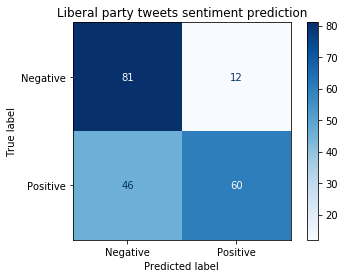

In [55]:
from sklearn.metrics import classification_report

print(classification_report(y_test_liberal, predictions_liberal, target_names=['Negative', 'Positive']));

plt.figure()
plot_confusion_matrix(model_liberal, X_test_liberal, y_test_liberal, display_labels=['Negative', 'Positive'],
                     cmap=plt.cm.Blues);
plt.title('Liberal party tweets sentiment prediction');

##### 2) Conservative party

In [56]:
Election_con = Election_2.loc[Election_2['Conservative'] == 1].copy()
Election_con['sentiment'].value_counts()

-1    461
 1    245
Name: sentiment, dtype: int64

In [57]:
Convertor = Feature_TFIDF(Election_con)
X_tf_con, y_tf_con= Convertor.convert('cleaned_text','sentiment')

X_train_con, X_test_con, y_train_con, y_test_con = train_test_split(X_tf_con, y_tf_con, 
                                                                test_size = 0.30, random_state=0, shuffle= True)
model_con = LogisticRegression(C=1.0, solver = 'newton-cg')
model_con.fit(X_train_con, y_train_con)
predictions_con = model_con.predict(X_test_con)
predictions_con_1 = model_con.predict(X_train_con)

train_accuracy_con = accuracy_score(y_train_con, predictions_con_1)
test_accuracy_con = accuracy_score(y_test_con, predictions_con)

print("\nTrain accuracy of LogisticRegression model: {}%".format(round(train_accuracy_con*100,2)))
print("\nTest accuracy of LogisticRegression model: {}%".format(round(test_accuracy_con*100,2)))


Train accuracy of LogisticRegression model: 77.33%

Test accuracy of LogisticRegression model: 64.62%


              precision    recall  f1-score   support

    Negative       0.64      0.99      0.78       134
    Positive       0.80      0.05      0.10        78

    accuracy                           0.65       212
   macro avg       0.72      0.52      0.44       212
weighted avg       0.70      0.65      0.53       212



<Figure size 432x288 with 0 Axes>

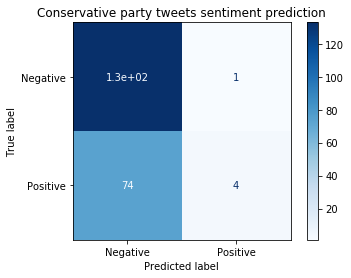

In [58]:
print(classification_report(y_test_con, predictions_con, target_names=['Negative', 'Positive']));

plt.figure()
plot_confusion_matrix(model_con, X_test_con, y_test_con, display_labels=['Negative', 'Positive'],
                     cmap=plt.cm.Blues);
plt.title('Conservative party tweets sentiment prediction');

##### 3) New Democratic party

In [59]:
Election_ndp = Election_2.loc[Election_2['New Democratic'] == 1].copy()
Election_ndp['sentiment'].value_counts()

 1    172
-1    107
Name: sentiment, dtype: int64

In [60]:
Convertor = Feature_TFIDF(Election_ndp)
X_tf_ndp, y_tf_ndp= Convertor.convert('cleaned_text','sentiment')

X_train_ndp, X_test_ndp, y_train_ndp, y_test_ndp = train_test_split(X_tf_ndp, y_tf_ndp, 
                                                                test_size = 0.30, random_state=0, shuffle= True)
model_ndp = LogisticRegression(C=100, solver = 'newton-cg')
model_ndp.fit(X_train_ndp, y_train_ndp)
predictions_ndp = model_ndp.predict(X_test_ndp)
predictions_ndp_1 = model_ndp.predict(X_train_ndp)

train_accuracy_ndp = accuracy_score(y_train_ndp, predictions_ndp_1)
test_accuracy_ndp = accuracy_score(y_test_ndp, predictions_ndp)

print("\nTrain accuracy of LogisticRegression model: {}%".format(round(train_accuracy_ndp*100,2)))
print("\nTest accuracy of LogisticRegression model: {}%".format(round(test_accuracy_ndp*100,2)))


Train accuracy of LogisticRegression model: 100.0%

Test accuracy of LogisticRegression model: 57.14%


              precision    recall  f1-score   support

    Negative       0.73      0.20      0.31        41
    Positive       0.55      0.93      0.69        43

    accuracy                           0.57        84
   macro avg       0.64      0.56      0.50        84
weighted avg       0.64      0.57      0.50        84



<Figure size 432x288 with 0 Axes>

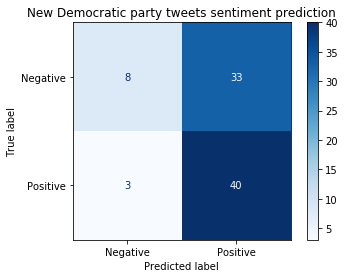

In [61]:
print(classification_report(y_test_ndp, predictions_ndp, target_names=['Negative', 'Positive']));

plt.figure()
plot_confusion_matrix(model_ndp, X_test_ndp, y_test_ndp, display_labels=['Negative', 'Positive'],
                     cmap=plt.cm.Blues);
plt.title('New Democratic party tweets sentiment prediction');

#### 4.5 Multiclass classification on the negative sentiment labels

**Procedure:**
1. Extract the tweets labelled with 'Negative' Sentiment
2. Encode the 10 negative reasons with numerical values
3. Apply the Term Frequency-Inverse Document Frequency (TFIDF) method to create features
4. Choose the 3 algorithms based on test accuracy (LogisticRegression, Multinomial Naive Bayes, Support Vector Machine)

**Results:** <br>

|Model|Train Accuracy|Test Accuracy|
|-----|----- --------|---- --------|
|Logistic regreesion| 99.86% |54.97%|
|Multinomial Naive Bayes| 98.01% |52.98%|
|Support Vector Machine| 99.86% | 56.62%|

In [62]:
Election_3 = Election_1.copy()
Election_negative = Election_3.loc[Election_3['sentiment'] == -1]
Election_negative.head(3)

,sentiment,negative_reason,cleaned_text
0,-1,Women Reproductive right and Racism,rosiebarton instead suggestion agree canadi...
2,-1,Economy,brantford s going cost 94 billion next 4 yea...
4,-1,Economy,canada taxpayers sick tired hard earned do...


In [63]:
Election_negative['negative_reason'].value_counts()

Others                                 364
Scandal                                270
Tell lies                              198
Economy                                 51
Women Reproductive right and Racism     45
Climate Problem                         41
Separation                              16
Privilege                               12
Healthcare                               5
Healthcare and Marijuana                 4
Name: negative_reason, dtype: int64

In [64]:
def reason_encoder (value):
    mapdict = {'Others': 0, 'Scandal': 1, 'Tell lies': 2, 'Economy':3,
               'Women Reproductive right and Racism':4, 'Climate Problem':5, 
               'Separation':6, 'Privilege':7, 'Healthcare':8, 'Healthcare and Marijuana':9}
    
    return mapdict[value]

Election_negative['negative_reason'] = Election_negative['negative_reason'].apply(reason_encoder)
Election_negative.head(3)

,sentiment,negative_reason,cleaned_text
0,-1,4,rosiebarton instead suggestion agree canadi...
2,-1,3,brantford s going cost 94 billion next 4 yea...
4,-1,3,canada taxpayers sick tired hard earned do...


In [65]:
Convertor = Feature_TFIDF(Election_negative)
X_tf_ng, y_tf_ng= Convertor.convert('cleaned_text','negative_reason')

X_train_ng, X_test_ng, y_train_ng, y_test_ng = train_test_split(X_tf_ng, y_tf_ng, 
                                                                test_size = 0.30, random_state=0, shuffle= True)

##### 1) Logistic Regression

In [66]:
model_ng1 = LogisticRegression(C=10, solver = 'newton-cg')
model_ng1.fit(X_train_ng, y_train_ng)
predictions_ng1 = model_ng1.predict(X_test_ng)
predictions_ng1_1 = model_ng1.predict(X_train_ng)

train_accuracy_ng1 = accuracy_score(y_train_ng, predictions_ng1_1)
test_accuracy_ng1 = accuracy_score(y_test_ng, predictions_ng1)

print("\nTrain accuracy of LogisticRegression model: {}%".format(round(train_accuracy_ng1*100,2)))
print("\nTest accuracy of LogisticRegression model: {}%".format(round(test_accuracy_ng1*100,2)))


Train accuracy of LogisticRegression model: 99.86%

Test accuracy of LogisticRegression model: 54.97%


##### 2) Multinomial Naive Bayes

In [67]:
from sklearn.naive_bayes import MultinomialNB

model_ng2 = MultinomialNB(alpha=0.1)
model_ng2.fit(X_train_ng, y_train_ng)
predictions_ng2 = model_ng2.predict(X_test_ng)
predictions_ng2_1 = model_ng2.predict(X_train_ng)

train_accuracy_ng2 = accuracy_score(y_train_ng, predictions_ng2_1)
test_accuracy_ng2 = accuracy_score(y_test_ng, predictions_ng2)

print("\nTrain accuracy of LogisticRegression model: {}%".format(round(train_accuracy_ng2*100,2)))
print("\nTest accuracy of LogisticRegression model: {}%".format(round(test_accuracy_ng2*100,2)))


Train accuracy of LogisticRegression model: 98.01%

Test accuracy of LogisticRegression model: 52.98%


##### 3) Support Vector Machine

In [68]:
from sklearn.svm import LinearSVC

model_ng3 = LinearSVC(random_state=0, tol=1e-5, C=1.0)
model_ng3.fit(X_train_ng, y_train_ng)
predictions_ng3 = model_ng3.predict(X_test_ng)
predictions_ng3_1 = model_ng3.predict(X_train_ng)

train_accuracy_ng3 = accuracy_score(y_train_ng, predictions_ng3_1)
test_accuracy_ng3 = accuracy_score(y_test_ng, predictions_ng3)

print("\nTrain accuracy of LogisticRegression model: {}%".format(round(train_accuracy_ng3*100,2)))
print("\nTest accuracy of LogisticRegression model: {}%".format(round(test_accuracy_ng3*100,2)))


Train accuracy of LogisticRegression model: 99.86%

Test accuracy of LogisticRegression model: 56.62%


### 5.0 Results and improvements

##### 1) For the first model which predicts the sentiment for each party
**Observations and discussion:**

- From figure presented in section 2.2.2, it can be found that on Twitter, the Liberal party receives approximately the same number of positive and negative comments. The Conservative party receives more negative comments than positive comments. The New Democratic party receives more postive comments than negative comments. 

- Based on the number of positive tweets received, in the public eye the Liberal party is the best party and the Conservative party is the second best, which aligns with the final result of the 2019 Federal election.

- The NLP analytics using LogisticRegression model yields a training accuracy of 99.87% and a test accuracy of 75.16%. The test accuracy of 75.16% is high enough to provide a general picture of the public sentiment towards the politics. Therefore, the NLP analytics may be used for estimating the general sentiment among the voters, but the election strategy should not be solely based on the predictions made by the NLP analytics since 75.16% is not that high enough to predict perfectly. 

- The LogisticRegression model applied to predict the sentiment for each of the three parties demonstrates a worse performance. The main reason of the worse performance is underfitting, due to lack of training samples. For example, the New Democratic party has the least number of tweets related, thus its model prediction accuracy is the lowest, which is 57.14%. 

**Improvements**

- The LogisticRegression model applied on the entire election dataset has a serious overfitting problem since its training accuracy is considerably higher than the test accuracy. One improvement is to reduce the number of features created by the TF-IDF method. For example, combine both word frequency and TF-IDF method, only keep the top 500 frequent word and their corresponding term frequency as the features, so that the number of features can be reduced to reduce the overfitting. 

- LogisticRegression model applied on the dataset for each of 3 parties has an underfitting problem since its test accuracy is low. One improvement is to increase the number of training samples for each party. 

##### 2) For the second model which predicts the sentiment label for each negative sentiment

**Observations and discussion:**

- Among all three algorithms (Logistic Regression, Multinomial Naive Bayes, Support Vector Machine), the Support Vector Machine (linear support vector classifier) has the highest test accuracy, which is 56.62%. All three algorithms  presents significant overfitting problem since their training accuracy are considerably higher than the test accuracy.

- Probable poor performance reason 1: Lack of tranining samples. There are in total 10 categories for negative reasons, however the training dataset is unbalanced and some categories only has few training sample available. For example, the 'Healthcare' only has 5 training samples and the 'Privilege' only has 12 training samples.

- Probable poor performance reason 2: Noise in the original dataset. The noise causes the algorithm to reach high complexitity which results in overfitting. For example, the hashtags such as #elxn43 and #cndpoli provide no meaningful information to the algorithm and negatively impact the model performance.

- Probable poor performance reason 3: The category 'Others' can be more specified. The model I applied mainly has difficulty in distingush between 'Others (0)' and 'Scandals (1)'. 'Others' also contains most of the training samples. A more detailed classification that converts 'Others' into small sub-categories may improve the performance.

**Improvements:**

- Use a balanced dataset with appropriate number (such as at least 300) of training samples for each category.
- Reduce the number of features to overcome the overfitting problem as mentioned in part 1). 

Examples of wrong predictions

In [69]:
predictions_ng3

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 2, 2, 0, 0, 1, 0, 3, 0, 2, 0, 0, 1, 0, 0, 1, 0, 1, 3, 5, 0, 5,
       0, 0, 0, 2, 2, 0, 2, 0, 1, 1, 0, 2, 1, 1, 2, 0, 0, 2, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 2, 0, 1, 0, 1, 0, 0, 0, 3, 2, 2, 0,
       0, 1, 0, 0, 2, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 1, 1, 5, 0,
       0, 2, 0, 0, 0, 2, 0, 2, 4, 0, 1, 0, 1, 3, 0, 2, 0, 0, 1, 0, 2, 2,
       0, 0, 2, 0, 1, 1, 3, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0,
       1, 0, 0, 1, 0, 2, 1, 1, 2, 1, 1, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 2, 0, 0, 3, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 4, 0, 3,
       0, 0, 1, 0, 1, 0, 1, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       1, 0, 4, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 1, 0, 2, 0, 0,
       1, 4, 0, 2, 0, 2, 1, 0, 2, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 2, 0, 1, 0, 1, 3, 1, 0, 2, 2, 3, 0, 0, 2,

In [70]:
y_test = pd.DataFrame(y_test_ng)
print(y_test.to_string())

      negative_reason
1404                0
1276                1
552                 0
670                 0
1046                0
1731                1
48                  1
417                 1
569                 1
1534                0
948                 1
1867                0
2106                3
431                 1
1794                2
93                  4
1191                1
308                 0
29                  2
128                 0
52                  1
869                 2
574                 1
575                 0
1967                2
1610                0
76                  1
166                 1
1480                0
2                   3
1552                1
1409                1
1287                1
820                 2
826                 0
1784                0
1632                0
682                 1
1946                4
488                 1
415                 3
2126                5
962                 2
1536                5
456       

In [71]:
# The predicted negative reason is 0 - Others
print(Election_3.loc[1276]['negative_reason'])

Scandal


In [72]:
print(Election_3.loc[1276]['cleaned_text'])

conversative representatives keep calling house asking need ride vote monday  right  giving ride polls definitely convince  elxn43 


In [73]:
# The predicted negative reason is 0 - Others
print(Election_3.loc[948]['negative_reason'])

Scandal


In [74]:
print(Election_3.loc[948]['cleaned_text'])

 ottawacitizen surprise   another post media endorsement   american owners must laughing asses voters buying bs    cdnpoli  elxn43 
